### **test**

In [129]:
import numpy as np
import pandas as pd
import gzip
import json
from collections import defaultdict
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from gensim.models import Word2Vec
import multiprocessing

# def filter_2017_data(file_path):
#     data_2017 = []
#     with gzip.open(file_path, 'r') as f:
#         for line in f:
#             entry = json.loads(line)
#             review_date = entry.get('review_date')
#             if review_date:
#                 try:
#                     date = datetime.strptime(review_date, "%B %d, %Y")
#                     if date.year == 2017 & date.year == 2016:
#                         data_2017.append(entry)
#                 except ValueError:
#                     continue
#     return data_2017

def load_data(file_path):
    dataset = []
    with gzip.open(file_path, 'rt', encoding='utf-8') as f:
        for line in f:
            dataset.append(json.loads(line))
    return dataset


## computing tfidf

In [130]:
def train_word2vec(data):
    sentences = [entry["review_text"].split() for entry in data if "review_text" in entry]
    model = Word2Vec(sentences, vector_size=100, window=5, min_count=2, workers=multiprocessing.cpu_count())
    
    item_word2vec = {}
    for entry in data:
        item_id = entry["item_id"]
        words = entry.get("review_text", "").split()
        vectors = [model.wv[word] for word in words if word in model.wv]
        item_word2vec[item_id] = np.mean(vectors, axis=0) if vectors else np.zeros(100)
    
    return model, item_word2vec

def compute_tfidf_features(data):
    vectorizer = TfidfVectorizer(max_features=500)
    review_texts = [entry.get('review_text', '') for entry in data]
    tfidf_matrix = vectorizer.fit_transform(review_texts)

    item_tfidf = {
        entry['item_id']: tfidf_matrix[i].toarray().flatten()
        for i, entry in enumerate(data)
    }
    return vectorizer, item_tfidf

In [131]:
def classify_rating(rating):
    if rating is None:
        return 'medium'

    rating = int(rating) 
    if rating >= 8:
        return 'high'
    elif 6 <= rating <= 7:
        return 'medium'
    else:
        return 'low'


df["rating"] = df["rating"].fillna(6) 
df["label"] = df["rating"].apply(classify_rating)

/var/folders/31/d8_mdwcs6k53znfr05m5f2mw0000gn/T/ipykernel_63940/3585008692.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["rating"] = df["rating"].fillna(6)
/var/folders/31/d8_mdwcs6k53znfr05m5f2mw0000gn/T/ipykernel_63940/3585008692.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["label"] = df["rating"].apply(classify_rating)


In [132]:
def prepare_data_fast(data, item_tfidf, item_word2vec):
    sia = SentimentIntensityAnalyzer()
    df = pd.DataFrame(data)

    df["sentiment_score"] = df["review_text"].fillna("").apply(lambda text: sia.polarity_scores(text)["compound"])
    df["tfidf_vector"] = df["item_id"].apply(lambda item_id: item_tfidf.get(item_id, np.zeros(500)))
    df["word2vec_vector"] = df["item_id"].apply(lambda item_id: item_word2vec.get(item_id, np.zeros(100)))
    user_history = defaultdict(list)
    df["user_history"] = df["user_id"].apply(lambda user_id: user_history[user_id][:])

    for _, row in df.iterrows():
        user_history[row["user_id"]].append(row["item_id"])

    df["label"] = df["rating"].apply(classify_rating)

    features = df[["user_id", "item_id", "sentiment_score", "tfidf_vector", "word2vec_vector", "user_history"]].to_dict("records")
    labels = df["label"].tolist()

    return features, labels

In [133]:
def calculate_similarity(item_id, user_history, item_tfidf, item_word2vec, w_tfidf=0.5, w_word2vec=0.5):
    if not user_history or item_id not in item_tfidf or item_id not in item_word2vec:
        return 0

    tfidf_vectors = [item_tfidf[item] for item in user_history if item in item_tfidf]
    tfidf_similarity = np.mean(cosine_similarity([item_tfidf[item_id]], tfidf_vectors)) if tfidf_vectors else 0

    word2vec_vectors = [item_word2vec[item] for item in user_history if item in item_word2vec]
    word2vec_similarity = np.mean(cosine_similarity([item_word2vec[item_id]], word2vec_vectors)) if word2vec_vectors else 0

    return w_tfidf * tfidf_similarity + w_word2vec * word2vec_similarity

In [134]:
def split_data(features, labels, test_size=0.2):
    data = list(zip(features, labels))
    np.random.shuffle(data)
    split_index = int(len(data) * (1 - test_size))
    return data[:split_index], data[split_index:]

In [135]:
def calculate_recommend_score(sentiment_score, similarity_score, w1, w2):
    return w1 * sentiment_score + w2 * similarity_score


In [136]:
def evaluate_weights(data, w1, w2, item_tfidf, item_word2vec):
    y_true = []
    y_pred = []
    for feature, label in data:
        sentiment_score = feature['sentiment_score']
        similarity_score = calculate_similarity(feature['item_id'], feature['user_history'], item_tfidf, item_word2vec)
        score = w1 * sentiment_score + w2 * similarity_score
        predicted_label = 'high' if score >= 0.5 else 'medium' if 0.5 > score >= 0.2 else 'low'
        y_true.append(label)
        y_pred.append(predicted_label)
    return np.mean(np.array(y_true) == np.array(y_pred))

In [137]:
def optimize_weights(train_data, item_tfidf, item_word2vec):
    best_w1, best_w2, best_accuracy = 0, 0, 0
    for w1 in np.linspace(0.1, 0.9, 11):
        w2 = 1 - w1
        accuracy = evaluate_weights(train_data, w1, w2, item_tfidf, item_word2vec)
        if accuracy > best_accuracy:
            best_w1, best_w2, best_accuracy = w1, w2, accuracy
    return best_w1, best_w2, best_accuracy

In [138]:
def final_recommendation(features, w1, w2, item_tfidf):
    recommendations = defaultdict(list)
    for feature in features:
        user_id = feature['user_id']
        item_id = feature['item_id']
        sentiment_score = feature['sentiment_score']
        similarity_score = calculate_similarity(item_id, feature['user_history'], item_tfidf)
        
        score = calculate_recommend_score(sentiment_score, similarity_score, w1, w2)
        recommendations[user_id].append((item_id, score))

    for user_id in recommendations:
        recommendations[user_id] = sorted(recommendations[user_id], key=lambda x: x[1], reverse=True)
    
    return recommendations

In [139]:
if __name__ == "__main__":
    print("Loading data...")
    data = load_data("renttherunway_final_data.json.gz")

    print("TF-IDF & Word2Vec...")
    vectorizer, item_tfidf = compute_tfidf_features(data)
    word2vec_model, item_word2vec = train_word2vec(data)

    print("processing data...")
    features, labels = prepare_data_fast(data, item_tfidf, item_word2vec)

    print("split data...")
    train_data, val_data = split_data(features, labels)

    print("optimize weights...")
    best_w1, best_w2, best_accuracy = optimize_weights(train_data, item_tfidf, item_word2vec)
    print(f"best weights: w1={best_w1}, w2={best_w2}, accuracy={best_accuracy}")

    print("finished")

Loading data...
TF-IDF & Word2Vec...
processing data...
split data...
optimize weights...
best weights: w1=0.9, w2=0.09999999999999998, accuracy=0.8309929561463304
finished


## --------------Accuracy----------------

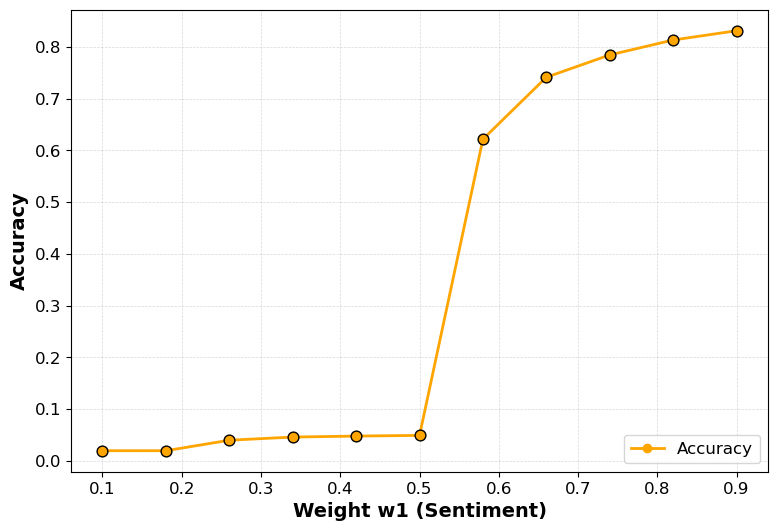

In [140]:
def evaluate_weights(data, w1, w2, item_tfidf, item_word2vec, w_tfidf=0.5, w_word2vec=0.5):
    y_true = []
    y_pred = []
    
    for feature, label in data:
        sentiment_score = feature['sentiment_score']
        similarity_score = calculate_similarity(
            feature['item_id'], feature['user_history'], 
            item_tfidf, item_word2vec, 
            w_tfidf, w_word2vec
        )
        
        score = w1 * sentiment_score + w2 * similarity_score
        predicted_label = 'high' if score >= 0.5 else 'medium' if 0.5 > score >= 0.2 else 'low'
        
        y_true.append(label)
        y_pred.append(predicted_label)
    
    return np.mean(np.array(y_true) == np.array(y_pred)) 

import matplotlib.pyplot as plt
import numpy as np

accuracies = []
weights = np.linspace(0.1, 0.9, 11)

for w1 in weights:
    w2 = 1 - w1 
    accuracy = evaluate_weights(
        train_data, w1, w2, 
        item_tfidf=item_tfidf, 
        item_word2vec=item_word2vec, 
        w_tfidf=0.5,  
        w_word2vec=0.5
    )
    accuracies.append(accuracy)


plt.figure(figsize=(9, 6), facecolor="white")
plt.plot(weights, accuracies, marker='o', linestyle='-', color="orange", linewidth=2, label="Accuracy") 
plt.scatter(weights, accuracies, color="orange", edgecolors='black', s=60, zorder=3) 

plt.xlabel("Weight w1 (Sentiment)", fontsize=14, fontweight="bold")
plt.ylabel("Accuracy", fontsize=14, fontweight="bold")

plt.legend(fontsize=12, loc="lower right")
plt.grid(color="gray", linestyle="--", linewidth=0.5, alpha=0.3)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()